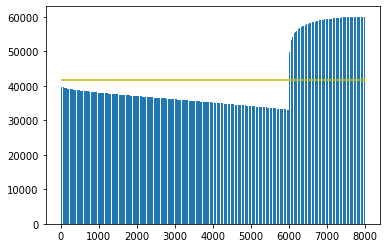

neighbours visited: [60080.0, 63191.0, 60080.0]
approximation ratio: 1.4388122145362172
time taken: 24.711125373840332


[8000, 10000, 1, 60080.0, 24.711125373840332]

In [1]:
import matplotlib.pyplot as plt
import Instances.Instances as gen
import functions.greedy_1 as G
p, m, allowableTime, sortedOrder = gen.importInstance('Instances/TestInstances/10 4 4 largeJobs 9.txt')
A = G.agent()
A.greedySearch(2, 1, m, p , sortedOrder)

In [3]:
A.cost

60080.0

In [2]:
import numpy as np
import time
from numba import njit

# see https://numba.readthedocs.io/en/stable/user/5minguide.html for how numba works
# note that numba should ideally use numpy arrays instead of python lists

X = np.random.randint(10**6, size = 10**5)

@njit
def fastMax(X):
    maximum = X[0]
    for i in range(1, len(X)):
        if X[i] > maximum:
            maximum = X[i]
    return maximum


def slowMax(X):
    maximum = X[0]
    for i in range(1, len(X)):
        if X[i] > maximum:
            maximum = X[i]
    return maximum


fastMax(X) # called once initially to compile the function for fair comparison when function is to be run repeatedly


initialTime = time.clock()
fastMax(X)
print("time taken to compute max with numba implementation: ", time.clock() - initialTime)


initialTime = time.clock()
slowMax(X)
print("time taken to compute max with python interpreter: ", time.clock() - initialTime)

AttributeError: module 'time' has no attribute 'clock'